# GloVe Embeddings using movie reviews dataset

    - Get all documents in list
    - Has each document to get it's sequence
    - Pass each document so that they are all of same size
    - load the GloVe word embeddings
    - Define deep learning model which takes 
        - size of vocab
        - desired dimensions of embeddings
        - size of input sequences
        - embeddings matrix read from words in our vocab and embeddings from GloVe
    - Once we train the model we can save the embeddings layer for use later
    
    This notebook assumes that you have the imdb reviews downloaded in unzipped in a directory called imdb along with the notebook. If not then please download the reviews.

In [1]:
import os
import random

imdb_dir = './imdb/train'
reviews = []
labels = []

def read_reviews_label (imdb_dir, label):
    dir_name = os.path.join(imdb_dir, label)
    
    for fname in os.listdir(dir_name):
        if (fname[-4:]=='.txt'):
            f = open (os.path.join(dir_name, fname), encoding='utf-8', mode='r')
            review = f.read()
            reviews.append(review)
            f.close()
            if (label == 'pos'):
                labels.append(1)
            if (label == 'neg'):
                labels.append(0)
                
#read positive & negative reviews
read_reviews_label(imdb_dir, 'pos')
read_reviews_label(imdb_dir, 'neg')

#shuffle the reviews and labels list together so that we have a good mix
mapIndexPosition = list(zip(reviews, labels))
random.shuffle(mapIndexPosition)
reviews, labels = zip(*mapIndexPosition)

print ('Number of reviews is %d'%(len(reviews)))
print ('Number of labels is %d'%(len(labels)))

Number of reviews is 25000
Number of labels is 25000


### Step 1: - Tokenize and Create Vocab

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import numpy as np

labels = np.array(labels)
#define the overall size of vocabulary taking into account all the reviews
max_words = 9999

# tokenize all reviews into tokens where each token represents a word. here we are restricting number of tokens to 9999
def tokenize_document(p_reviews, max_words):
    tokenizer = Tokenizer(num_words=max_words)
    tokenizer.fit_on_texts(p_reviews)
    
    sequences = tokenizer.texts_to_sequences(p_reviews)
    print ('Number of sequences is ', len(sequences))
    
    word_index  = tokenizer.word_index
    
    return (word_index, sequences)

(word_index, sequences) = tokenize_document(reviews, max_words)

words_per_review = 999
# pad each sequence so that each sequence (which represents one review) has same shape.
def pad_documents (sequences, words_per_review):
    padded_reviews = pad_sequences (sequences, maxlen=words_per_review, padding='post')
    return padded_reviews

padded_reviews = pad_documents(sequences, words_per_review)

print ('Vocabulary size is %d and size of padded reviews is %s'%(len(word_index), padded_reviews.shape))

Using TensorFlow backend.


Number of sequences is  25000
Vocabulary size is 88582 and size of padded reviews is (25000, 999)


#### Load GloVe embeddings

In [7]:
embedding_dir = './'
embeddings_index = {}

f = open ('glove.6B.100d.txt','r', encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word]=coefs

f.close()
print ('Found %s word embeddings'%(len(embeddings_index)))

Found 400000 word embeddings


#### Prepare Matrix of our vocab and GloVe embeddings

In [8]:
embedding_dir = './'
loaded_embeddings_matrix = np.zeros((max_words, 100))

for word, i in word_index.items():
    if (i<max_words):
        if word in embeddings_index.keys():
            embedding_vector = embeddings_index[word]
            loaded_embeddings_matrix[i] = embedding_vector

print (loaded_embeddings_matrix.shape)

(9999, 100)


#### Retrain model on loaded embeddings

In [9]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
from keras.utils.vis_utils import plot_model

loaded_model = Sequential()
loaded_model.add(Embedding(input_dim=(len(word_index)+1), output_dim=100, input_length=(words_per_review)))
loaded_model.add(Flatten())

loaded_model.layers[0].set_weights = ([loaded_embeddings_matrix])
loaded_model.layers[0].trainable = False

loaded_model.add(Dense(1, activation='sigmoid'))
loaded_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
loaded_model.summary()

#plot model and save as png file
#plot_model(model, to_file='reviews_embedding_model.png', show_shapes=True)

#fit the model on training data
history = loaded_model.fit (padded_reviews, labels, validation_split=0.3, epochs=20)

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 999, 100)          8858300   
_________________________________________________________________
flatten_1 (Flatten)          (None, 99900)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 99901     
Total params: 8,958,201
Trainable params: 99,901
Non-trainable params: 8,858,300
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Train on 17500 samples, validate on 7500 samples
Epoch 1/20
17500/17500 [==============================] - 8s 472us/step - loss: 0.7263 - acc: 0.5126 - val_loss: 0.6849 - val_acc: 0.5329
Epoch 2/20
17500/17500 [==============================] - 8s 465us/step - loss: 0.65

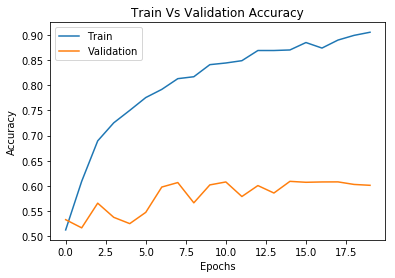

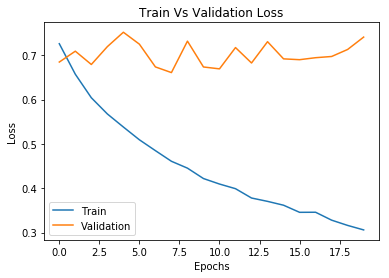

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

## Visualizing Model Accuracy on Training & Validation data
trainAccHistory = history.history['acc']
validationAccHistory = history.history['val_acc']

plt.plot(trainAccHistory)
plt.plot(validationAccHistory)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train Vs Validation Accuracy')
plt.legend(['Train','Validation'])
plt.show()

trainLossHistory = history.history['loss']
validationLossHistory = history.history['val_loss']

plt.plot(trainLossHistory)
plt.plot(validationLossHistory)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train Vs Validation Loss')
plt.legend(['Train','Validation'])
plt.show()

## Summary

    - We see that after loading GloVe word embeddings, our model is able to give fairly accurate results
    - Clearly accuracy is high on training data compared to validation data
    - Model can be trained further by training on more number of epocs and by applying other techniques like regularisation, drop out, scaling network etc.